https://medium.com/analytics-vidhya/semantic-search-engine-using-nlp-cec19e8cfa7e

# The Youtube API

In [1]:
# Youtube API with Python

from googleapiclient.discovery import build
import pprint

API_KEY = # API_KEY
youtube = build('youtube', 'v3', developerKey=API_KEY)

def search_channels(query, max_results=50):
    request = youtube.search().list(
        part="snippet",
        type="channel",
        q=query,
        maxResults=max_results
    )
    response = request.execute()
    channels = []
    i = 0
    for item in response.get('items', []):
        if i > 10:
            break
        i += 1
        channel_id = item['snippet']['channelId']
        channels.append({
            'channelId': channel_id,
            'channelTitle': item['snippet']['channelTitle'],
            'description': item['snippet']['description'],
            'latestVideos': get_latest_videos(channel_id)
        })
    return channels

def get_latest_videos(channel_id, max_results=10):
    # Get the uploads playlist ID
    channel_response = youtube.channels().list(
        part='contentDetails',
        id=channel_id
    ).execute()
    uploads_playlist_id = channel_response['items'][0]['contentDetails']['relatedPlaylists']['uploads']

    # Fetch videos from the playlist
    playlist_request = youtube.playlistItems().list(
        part="snippet",
        playlistId=uploads_playlist_id,
        maxResults=max_results
    )
    try:
        playlist_response = playlist_request.execute()
        videos = []
        for item in playlist_response['items']:
            video_id = item['snippet']['resourceId']['videoId']
            videos.append({
                'videoId': video_id,
                'title': item['snippet']['title'],
                'description': item['snippet']['description'],
                'publishedAt': item['snippet']['publishedAt']
            })
        return videos
    except:
        return []

channels = search_channels('manga')
pprint.pprint(channels)


[{'channelId': 'UCRWUqJwTan9QFDoVJLFIwJw',
  'channelTitle': 'La chaîne Mangas',
  'description': 'Bienvenue sur La Chaîne Mangas, la chaîne YouTube '
                 "incontournable de l'actu manga et anime. Culte ou inédits, "
                 'le meilleur des ...',
  'latestVideos': [{'description': 'Sur La Chaîne Mangas, retrouvez toute '
                                   'l’actu de l’univers Manga !\n'
                                   'Abonnez-vous vite à la chaîne : '
                                   'http://bit.ly/2davQGs \n'
                                   '\n'
                                   '🔴 RÉSEAUX SOCIAUX\n'
                                   'Twitter      ► '
                                   'https://twitter.com/LaChaineMangas\n'
                                   'Facebook ► '
                                   'https://www.facebook.com/LaChaineMangas/',
                    'publishedAt': '2023-08-09T16:00:37Z',
                    'title': 'Izumo - Episod

In [2]:
# Video Transcript

from youtube_transcript_api import YouTubeTranscriptApi

# Replace 'video_id' with the ID of the YouTube video
video_id = 'video_id'

try:
    transcript_list = YouTubeTranscriptApi.get_transcript(video_id)
    for transcript in transcript_list:
        print(transcript['text'])
except Exception as e:
    print(f"An error occurred: {e}")


An error occurred: 
Could not retrieve a transcript for the video https://www.youtube.com/watch?v=video_id! This is most likely caused by:

Subtitles are disabled for this video

If you are sure that the described cause is not responsible for this error and that a transcript should be retrievable, please create an issue at https://github.com/jdepoix/youtube-transcript-api/issues. Please add which version of youtube_transcript_api you are using and provide the information needed to replicate the error. Also make sure that there are no open issues which already describe your problem!


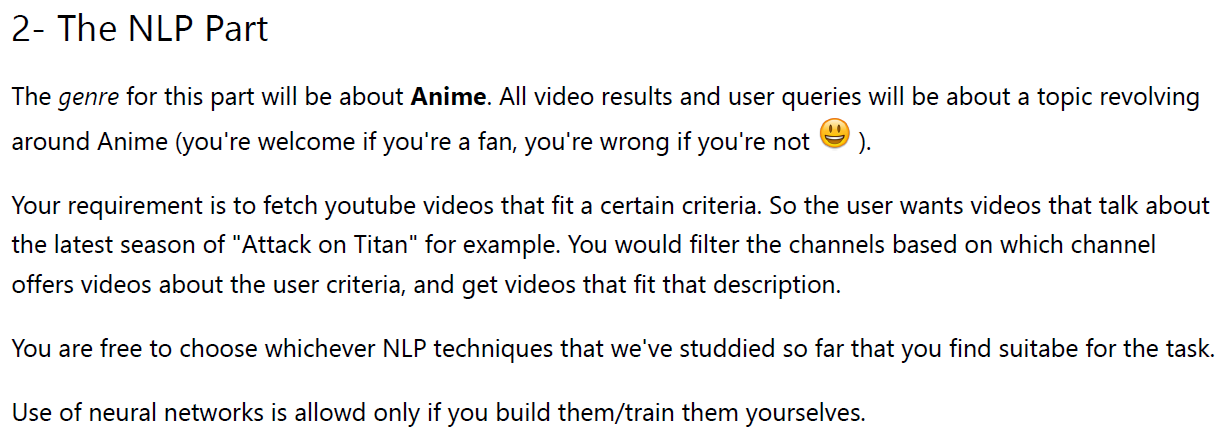

In [3]:
# Basic import

import pandas as pd
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string
import re
import dictionary
import gensim


In [4]:
# Create the DataFrame using what we request from Youtube
# Using the Youtube API, we obtained a list of youtube channels with a list of their latest videos

df = pd.DataFrame(columns=['Channel_ID', 'Channel_Title', 'Video_ID', 'Video_Title', 'Video_Description', 'Published_At'])

for channel in channels:
    for video in channel['latestVideos']:
        new_row = pd.DataFrame({
            'Channel_ID': [channel['channelId']],
            'Channel_Title': [channel['channelTitle']],
            'Video_ID': [video['videoId']],
            'Video_Title': [video['title']],
            'Video_Description': [video['description']],
            'Published_At': [video['publishedAt']]
        })
        df = pd.concat([df, new_row], ignore_index=True)

df.head()


,Channel_ID,Channel_Title,Video_ID,Video_Title,Video_Description,Published_At
0,UCRWUqJwTan9QFDoVJLFIwJw,La chaîne Mangas,eXfQIrmaO2M,Izumo - Episode 11 | La vie déchaînée,"Sur La Chaîne Mangas, retrouvez toute l’actu d...",2023-08-09T16:00:37Z
1,UCRWUqJwTan9QFDoVJLFIwJw,La chaîne Mangas,6sQypTlTJuo,Izumo - Episode 10 | Yomotsuhirasaka,"Sur La Chaîne Mangas, retrouvez toute l’actu d...",2023-08-03T16:00:05Z
2,UCRWUqJwTan9QFDoVJLFIwJw,La chaîne Mangas,4J7PwsvPaCs,Izumo - Episode 9 | Celui qu'il faut protéger,"Sur La Chaîne Mangas, retrouvez toute l’actu d...",2023-07-23T16:00:02Z
3,UCRWUqJwTan9QFDoVJLFIwJw,La chaîne Mangas,xQgk_86fA0c,Un SUPER concours de Cosplay avec de SUPER par...,,2023-07-20T17:25:23Z
4,UCRWUqJwTan9QFDoVJLFIwJw,La chaîne Mangas,xhK7Oe1PIvk,Izumo - Episode 8 | Un moment paisible,"Sur La Chaîne Mangas, retrouvez toute l’actu d...",2023-07-20T16:00:44Z


In [5]:
# Data cleaning and Pre-processing
# Before tokenizing the description of Youtube videos, we want to remove unnecessary words and characters
# We're going to use regular expressions for the matching pattern to remove/replace them
# https://www.pinterest.fr/pin/regex-cheatsheet--487092515931233428/

spacy_nlp = spacy.load('en_core_web_sm')

#create list of punctuations and stopwords for the english language
punctuations = string.punctuation
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# function for data cleaning and processing
# This can be further enhanced by adding / removing reg-exps as desired.

def spacy_tokenizer(sentence):
 
    #remove distracting single quotes
    sentence = re.sub('\'','',sentence)

    #remove digits and words containing digits
    sentence = re.sub('\w*\d\w*','',sentence)

    #replace extra spaces with single space
    sentence = re.sub(' +',' ',sentence)
    
    #remove non-breaking new line characters
    sentence = re.sub(r'\n',' ',sentence)
    
    #remove punctunations
    sentence = re.sub(r'[^\w\s]',' ',sentence)
    
    #creating token object
    tokens = spacy_nlp(sentence)
    
    #lower, strip and lemmatize
    tokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens]
    
    #remove stopwords, punctuations, and exclude words less than 2 characters
    tokens = [word for word in tokens if word not in stop_words and word not in punctuations and len(word) > 2]
    
    #return tokens
    return tokens


In [6]:
# Cleaning and Tokenizing

print ('Cleaning and Tokenizing...')

df['Video_Description_tokenized'] = df['Video_Description'].map(lambda x: spacy_tokenizer(x))
df_description = df['Video_Description_tokenized']

df.head()

Cleaning and Tokenizing...


,Channel_ID,Channel_Title,Video_ID,Video_Title,Video_Description,Published_At,Video_Description_tokenized
0,UCRWUqJwTan9QFDoVJLFIwJw,La chaîne Mangas,eXfQIrmaO2M,Izumo - Episode 11 | La vie déchaînée,"Sur La Chaîne Mangas, retrouvez toute l’actu d...",2023-08-09T16:00:37Z,"[sur, chaîne, mangas, retrouvez, toute, actu, ..."
1,UCRWUqJwTan9QFDoVJLFIwJw,La chaîne Mangas,6sQypTlTJuo,Izumo - Episode 10 | Yomotsuhirasaka,"Sur La Chaîne Mangas, retrouvez toute l’actu d...",2023-08-03T16:00:05Z,"[sur, chaîne, mangas, retrouvez, toute, actu, ..."
2,UCRWUqJwTan9QFDoVJLFIwJw,La chaîne Mangas,4J7PwsvPaCs,Izumo - Episode 9 | Celui qu'il faut protéger,"Sur La Chaîne Mangas, retrouvez toute l’actu d...",2023-07-23T16:00:02Z,"[sur, chaîne, mangas, retrouvez, toute, actu, ..."
3,UCRWUqJwTan9QFDoVJLFIwJw,La chaîne Mangas,xQgk_86fA0c,Un SUPER concours de Cosplay avec de SUPER par...,,2023-07-20T17:25:23Z,[]
4,UCRWUqJwTan9QFDoVJLFIwJw,La chaîne Mangas,xhK7Oe1PIvk,Izumo - Episode 8 | Un moment paisible,"Sur La Chaîne Mangas, retrouvez toute l’actu d...",2023-07-20T16:00:44Z,"[sur, chaîne, mangas, retrouvez, toute, actu, ..."


In [7]:
# Creation of a dictionary, a corpus, and joining the two

import gensim
from gensim import corpora

# Create a Gensim Dictionary from the tokenized documents (Assigns an ID for each word)
dictionary = corpora.Dictionary(df_description)

# Create a corpus in the bag-of-words format (Count how many times the word appears per description)
corpus = [dictionary.doc2bow(doc) for doc in df_description]

# Get word frequencies for the first three documents in the corpus ((ID, frequency) to (the word of the ID, frequency))
word_frequencies = [[(dictionary[id], frequency) for id, frequency in line] for line in corpus]


In [8]:
"""Tf-Idf means, Term frequency-Inverse Document Frequency. 
It is a commonly used NLP model that helps you determine the most important words in each document in the corpus. 
Once the Tf-Idf is build, pass it to LSI model and specify the num of features to build"""

from gensim import models, similarities

# Creating the TF-IDF model from the corpus
anime_tfidf_model = gensim.models.TfidfModel(corpus, id2word=dictionary)
# Applying the TF-IDF model to the corpus
anime_tfidf_corpus = anime_tfidf_model[corpus]

# Creating the LSI model from the TF-IDF corpus
# The parameter num_topics is where you define the number of features or dimensions you want the LSI model to extract.
anime_lsi_model = gensim.models.LsiModel(anime_tfidf_corpus, id2word=dictionary, num_topics=300)
# Applying the LSI model to the TF-IDF corpus
anime_lsi_corpus = anime_lsi_model[anime_tfidf_corpus]

# Creating the similarity index from the LSI corpus
anime_index = similarities.MatrixSimilarity(anime_lsi_corpus, num_features=anime_lsi_model.num_topics)


The LSI (Latent Semantic Indexing) model is used in natural language processing to reduce text data dimensionality and uncover hidden semantic relationships, thereby enhancing document search and classification by capturing deeper meanings beyond mere word occurrences.


In [9]:
#Creation of the fucntion search_similar_anime

from operator import itemgetter

def search_similar_anime(search_term):

    query_bow = dictionary.doc2bow(spacy_tokenizer(search_term))
    query_tfidf = anime_tfidf_model[query_bow]
    query_lsi = anime_lsi_model[query_tfidf]

    anime_index.num_best = 5

    anime_list = anime_index[query_lsi]

    anime_list.sort(key=itemgetter(1), reverse=True)
    anime_names = []

    for j, anime in enumerate(anime_list):

        anime_names.append (
            {
                'Relevance': round((anime[1] * 100),2),
                'Channel Title': df['Channel_Title'][anime[0]],
                'Video Title': df['Video_Title'][anime[0]],
                'Video Description': df['Video_Description'][anime[0]]
            }

        )
        if j == (anime_index.num_best-1):
            break

    return pd.DataFrame(anime_names, columns=['Relevance','Channel Title', 'Video Title','Video Description'])

In [12]:
# Result of the search query

result_search = search_similar_anime('One Piece')
display(result_search)

,Relevance,Channel Title,Video Title,Video Description
0,57.73,Glénat Manga Officiel,"LE GRAND QUIZ ONE PIECE ft. Leïla, Ringo, Winn...",Grand quiz One Piece avec un plateau d&#39;exp...
1,43.90,Glénat Manga Officiel,Glénat Manga Live - ONE PIECE 106 en direct du...,"Dans cet épisode spécial, en direct du Japon, ..."
2,43.04,Glénat Manga Officiel,Préparez-vous pour la Nuit One Piece !,🏴‍☠️ La Nuit One Piece revient !! 🏴‍☠️\n\nRend...
3,40.62,Glénat Manga Officiel,Revivez la Nuit One Piece 2022 !,Rendez-vous le 29 septembre pour la Nuit One P...
4,19.52,Manga Trash,4 ANIMES TUÉS par NETFLIX 📺,Netflix a ruiné Jojo Bizarre Aventure !\nQui s...


In [13]:
# The channels based on which channel offers videos about the user criteria

result_search["Channel Title"].value_counts()

Glénat Manga Officiel    4
Manga Trash              1
Name: Channel Title, dtype: int64